In [1]:
from datetime import datetime
import os
import sys
import distutils
import argparse
from run_model import RunModel
from bayescmd.util import findBaseDir
import pandas as pd
import numpy as np
BASEDIR = findBaseDir('BayesCMD')



STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
.
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD


In [2]:
data_path = "/home/buck06191/Dropbox/phd/hypothermia/Piglet Data/filtered_data"

data_files = ['LWP475_filtered.csv', 'LWP479_filtered.csv',
              'LWP481_filtered.csv', 'LWP484_filtered.csv']

data_storage = "./data/clean_hypothermia/"

In [40]:
dfs = []
cnames = ["Time", "temp", "oxCCO", "HbO2", "HHb", "P_a", "SaO2sup"]
for f in data_files:
    df=pd.read_csv(os.path.join(data_path, f), names=cnames, skiprows=1)
    df['Time'] = pd.to_datetime(df['Time'])
    df['t'] = df['Time']-df['Time'][0]
    df.drop('Time', axis=1, inplace=True)
    df['t']/=np.timedelta64(1,'s')
    dfs.append(df)
    df.to_csv(os.path.join(data_storage, "cleaned_"+f), index=None)

In [64]:
config = {
    "model_name": "bp_hypothermia",
    "parameters":{},
    "inputs": ["temp", "P_a"],# "SaO2sup", "P_a"],
    "targets": ["CCO"]
}

In [65]:
outputs = []
import subprocess
for i, f in enumerate(data_files):
    config['outf'] = os.path.splitext(f)[0]
    config['parameters']['CCO_offset'] = dfs[i]['oxCCO'][0]
    print(config['parameters'])
    m = RunModel(config, os.path.join(data_storage, "cleaned_"+f), os.path.join(data_storage, "sim_runs"))
    try:
        outputs.append(m.generateOutput())
        m.writeOutput()
    except subprocess.CalledProcessError as e:
        print("Error output:\n", e.output)



{'CCO_offset': -1.4164731075888235}
output written to ./data/clean_hypothermia/sim_runs/model_run_output_LWP475_filtered.csv
{'CCO_offset': -1.7428063450021118}
output written to ./data/clean_hypothermia/sim_runs/model_run_output_LWP479_filtered.csv
{'CCO_offset': -1.7304728743737063}
output written to ./data/clean_hypothermia/sim_runs/model_run_output_LWP481_filtered.csv
{'CCO_offset': 0.2378649695142859}
Error output:
 b' EXIT OF RADAU5 AT X=       -0.1000E+04\n  MATRIX IS REPEATEDLY SINGULAR, IER=           2\n EXIT OF RADAU5 AT X=       -0.1000E+01\n  MATRIX IS REPEATEDLY SINGULAR, IER=           2\nERR\tt\tCCO\n-4\t-1\t0.23784819854365774\n EXIT OF RADAU5 AT X=        0.0000E+00\n  MATRIX IS REPEATEDLY SINGULAR, IER=           2\n-4\t0\t0.23784819854365774\n EXIT OF RADAU5 AT X=        0.1100E+02\n  MATRIX IS REPEATEDLY SINGULAR, IER=           2\n-4\t11\t0.23784819854365774\n EXIT OF RADAU5 AT X=        0.2100E+02\n  MATRIX IS REPEATEDLY SINGULAR, IER=           2\n-4\t21\t0.2378

In [66]:
len(outputs)

3

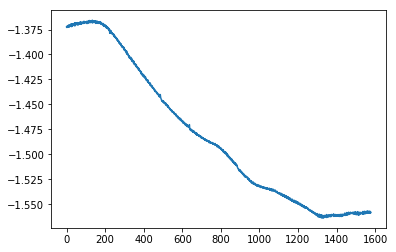

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(outputs[0]['CCO'])

In [68]:
dfs[0]['pred_oxCCO'] =outputs[0]['CCO']

/home/buck06191/.virtualenvs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


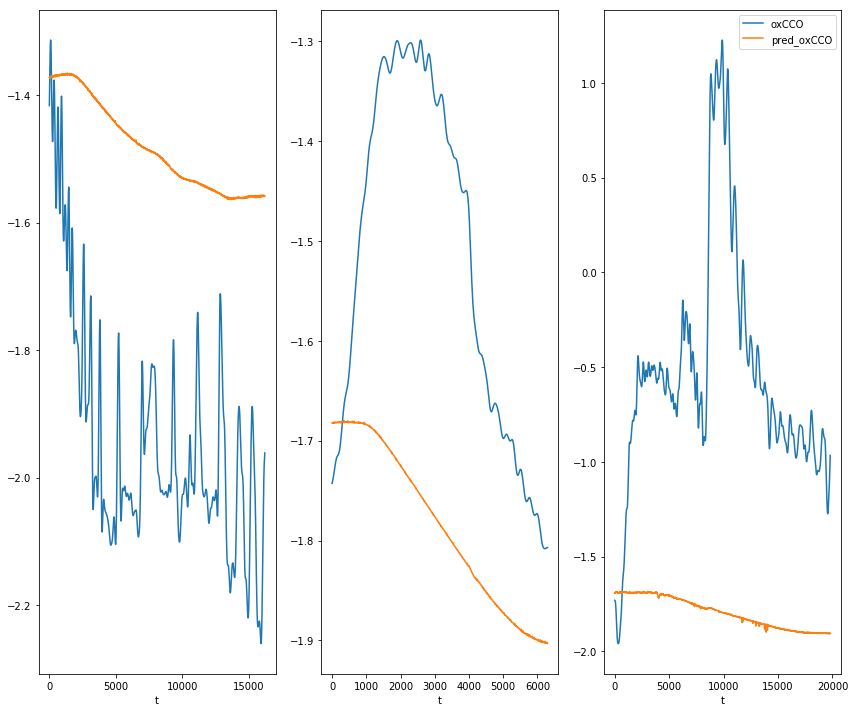

In [70]:
fig, ax = plt.subplots(nrows= 1, ncols=len(outputs))

fig.set_size_inches(12, 10)
for i in range(len(outputs)):
    dfs[i]['pred_oxCCO'] =outputs[i]['CCO']
    if i != 2:
        dfs[i].plot(x='t', y=['oxCCO', 'pred_oxCCO'], ax= ax[i], legend=False)
    else:
        dfs[i].plot(x='t', y=['oxCCO', 'pred_oxCCO'], ax= ax[i], legend=True)
        ax[i].legend(loc='upper right', bbox_to_anchor=(1, 1))
        
plt.tight_layout()